<a href="https://colab.research.google.com/github/maxbentley/datasciencefund/blob/main/Max_BentU5Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 5 Project/Semester 1 Final: Using Bat Speed to Predict wOBA

## Introduction

For this project, I decided to examine the relationship between an MLB player's average bat speed and their weighted on-base average (wOBA). wOBA is a general offensive statistic that measures a player's offensive output as it relates to run value. If you want a more detailed explanation of what it is or how to calculate it, you can read [this FanGraphs article](https://library.fangraphs.com/offense/woba/) to get a better idea.

### Importing libraries + data

In [ ]:
# libraries

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

In [ ]:
# i always imagine a personification of google colab groaning at me every time i have to import preliz
# "auuuuuugh do you REALLY need to install a new library to do this??? fine."

!pip install preliz
import preliz as pz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.2/514.2 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 17.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


As you may remember from project 4, Statcast doesn't have positional data, so I had to grab it from some fantasy baseball website. Statcast also for whatever reason doesn't allow you to directly specify the minimum # of competitive swings on their "search" tab--it's in a different database that doesn't have SLG data along with it. So I have to join three different tables :(

In [ ]:
# data (three datasets)

pos_data = pd.read_csv('https://raw.githubusercontent.com/maxbentley/datasciencefund/refs/heads/main/Data/mlb-player-stats-Batters.csv') # positional data
bspeed_data = pd.read_csv('https://raw.githubusercontent.com/maxbentley/datasciencefund/refs/heads/main/Data/bat-tracking.csv') # bat speed data (min 200 competitive swings)
woba_data = pd.read_csv('https://raw.githubusercontent.com/maxbentley/datasciencefund/refs/heads/main/Data/player_wOBA.csv') # woba data (min 150 PAs)

In [ ]:
# merge

pos_bat = pd.merge(pos_data, bspeed_data, on='name', how='inner') # merge pos/bat speed
bat_woba = pd.merge(pos_bat, woba_data, on='name', how='inner') # merge resulting w/ slg
bat_woba

,pos,name,avg_bat_speed,woba
0,SS,"Abrams, CJ",72.245374,0.322
1,OF,"Abreu, Wilyer",74.554859,0.336
2,SS,"Adames, Willy",73.615644,0.342
3,OF,"Adell, Jo",76.674033,0.296
4,SS,"Ahmed, Nick",67.866120,0.248
...,...,...,...,...
399,OF,"Yastrzemski, Mike",70.946955,0.319
400,OF,"Yelich, Christian",73.174690,0.391
401,1B,"Yepez, Juan",70.480310,0.333
402,DH,"Yoshida, Masataka",70.944681,0.336


I decided to only count players with a minimum of 200 competitive swings and 150 PAs (plate appearances) to get a solid sample of ~400 players of varying importance (everyday players and backups).

### First Impressions

Let's see the plot!

<Axes: xlabel='avg_bat_speed', ylabel='woba'>

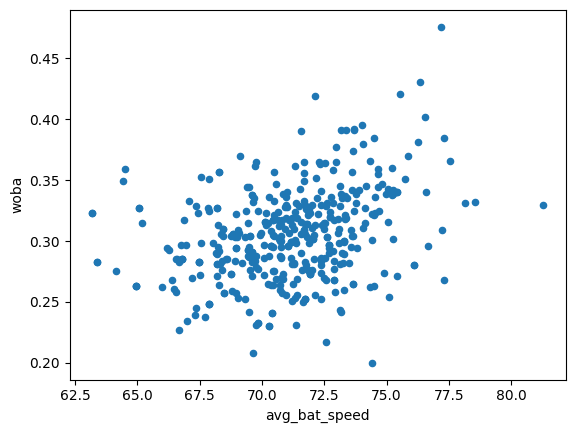

In [ ]:
bat_woba.plot.scatter(x='avg_bat_speed', y='woba')

The correlation isn't going to be extremely strong, but there is definitely some trend here. Not entirely sure if it's linear or ever-so-slightly exponential, leaning towards the former ATM.

(For those wondering about the two big outliers: the high-wOBA player is Aaron Judge, while the high bat speed player is Giancarlo Stanton. Both play for the Yankees.)

What about at each position?

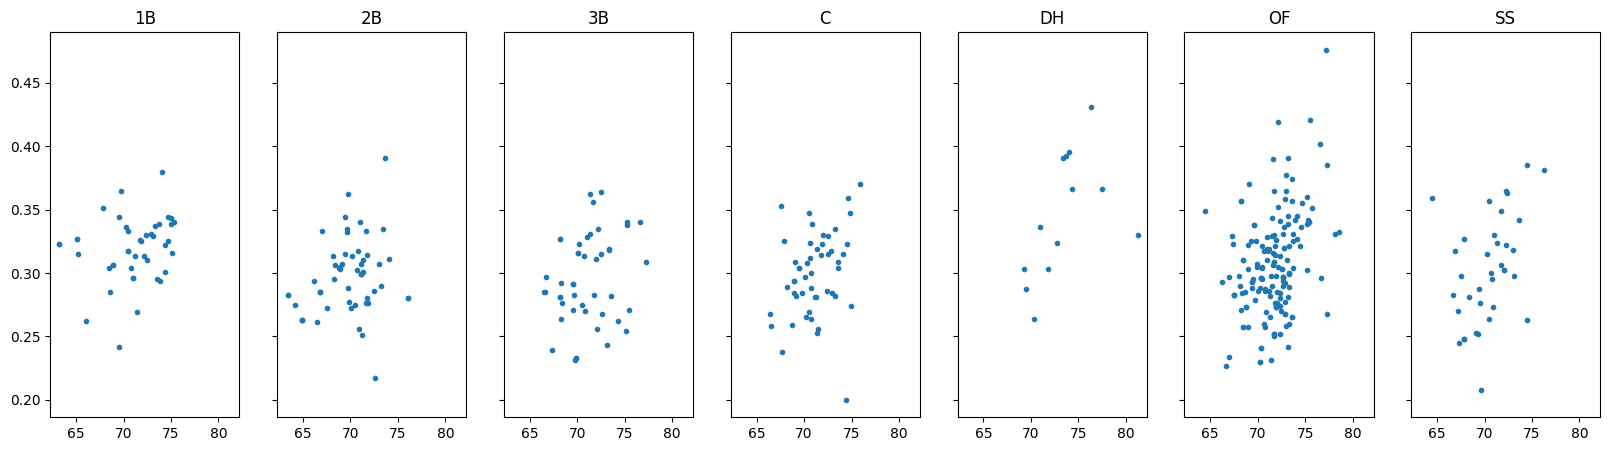

In [ ]:
# code shamelessly stolen from unit 5 notes

# convert pos column from object to category type
bat_woba.pos = bat_woba.pos.astype('category')

#this is an array of the basketball positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = bat_woba.pos.cat.codes.values

#an array of the strings that represent position
pos_codes = bat_woba.pos.cat.categories

#puts coords in a dict, so pymc can read them
bsb_coords = {"pos": pos_codes}


#set up the 7 plots
_, ax = plt.subplots(1, 7, figsize=(20, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

#make a scatter plot for each position
for i, p in enumerate(pos_codes):
    ax[i].scatter(
        x = bat_woba.query('pos == @p')['avg_bat_speed'],
        y =  bat_woba.query('pos == @p')['woba'],
        marker=".")
    ax[i].set_title(f"{p}")



Interesting, there's a decent bit of variability. The more power-heavy positions--OF and DH (small sample), mainly--look like they have an upward linear trend (albeit with lots of clumping), while others, mainly 2B and 3B, look like there's no correlation between the two stats.

## Attempt 1


For my first attempt, I'll try a non-hierarchical model. I think this could work pretty well, mainly because I think the positions are independent of one another. DHs and OFs are traditionally "power" hitters, who optimize their contact to try and get as many extra-base hits as possible, and so most of their offensive output will be driven by their slugging, which bat speed indirectly measures. On the other hand, infield positions like second and third base are often occupied by "contact" hitters, which try to optimize their contact to simply get on base consistently instead, which won't require as much power since you only need to get your batted ball over the infielders' heads to get a base hit.

I'm gonna try first by throwing a bunch of weak (for the set) normal priors in there and seeing where it sticks. My guess is that the model won't shoot itself, which will give me a good idea of how the line should look (and if I'm lucky, get a great distribution first try). For the alpha and beta parameters of my correlation line, I'm going with a Normal with an average of 70mph and a standard deviation of 5mph as well as a Normal with an average of 0.02 and a standard deviation of 0.05. The average bat speed seems to be a little greater than 70mph overall, but the large standard deviation I'm giving the model will hopefully even it out for each position (which, depending on the position, may be lower). The beta parameter seems incredibly small at first glance (hundredths!), but that's because the ratio of bat speed in mph to wOBA is really high, since wOBA essentially ranges from .2 to .5 (and most of the time is well in between the two values) while bat speed is in the double digits, and so the raw value of the slope will be low even if the correlation is high/direct. The standard deviation is also probably going to be very low for this reason.

I'm also gonna try out a Normal here for the likelihood, the main reason being that the set *should* be relatively normal, as it's just a collection of people of varying skillsets, which lends itself to normality pretty well. wOBA is also continuous (it's essentially a bunch of percentages), so it makes sense to use a continuous likelihood.

<Axes: >

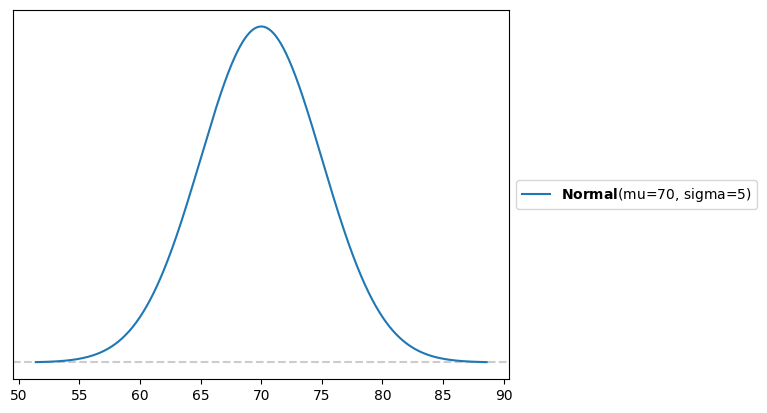

In [ ]:
# alpha prior
pz.Normal(mu = 70, sigma = 5).plot_pdf()

<Axes: >

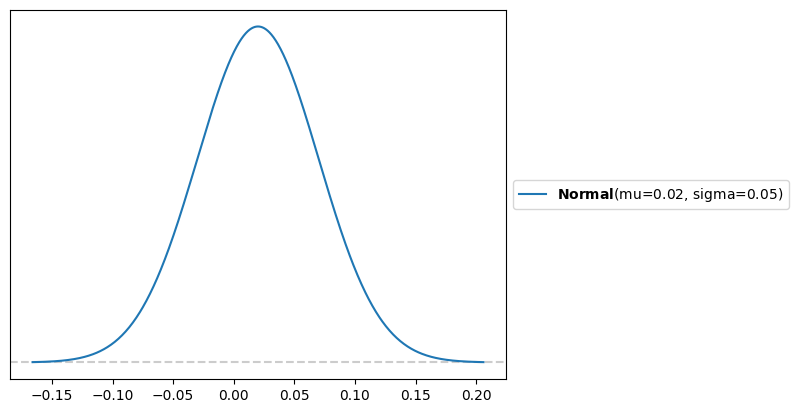

In [ ]:
# beta prior
pz.Normal(mu = 0.02, sigma = 0.05).plot_pdf()

<Axes: >

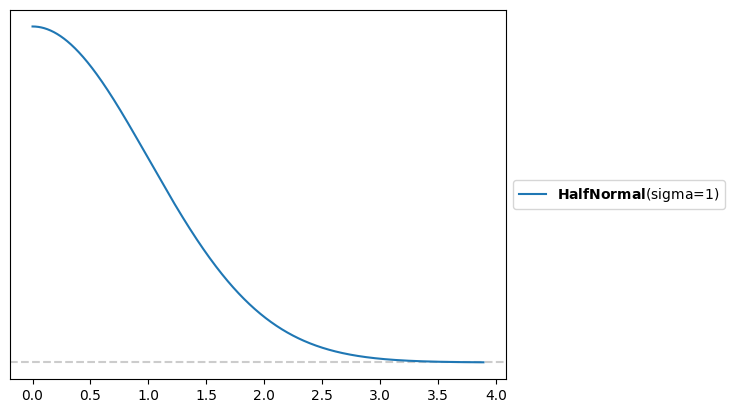

In [ ]:
# sigma prior
pz.HalfNormal(sigma = 1).plot_pdf()

In [ ]:
#nh for non hierarchical
with pm.Model(coords=bsb_coords) as bat_nh:
    #priors
    α = pm.Normal("α", mu=70, sigma=5, dims="pos")
    β = pm.Normal("β", mu=(0.05 / 2.5), sigma=0.05, dims="pos")
    σ = pm.HalfNormal("σ", 1)

    #likelihood
    #the linear part of the model is put directly into mu
    y = pm.Normal("y_pred",
                  mu=α[pos_idx] + β[pos_idx] * bat_woba['avg_bat_speed'],
                  sigma=σ,
                  observed=bat_woba['woba'])
    idata_nh_b1 = pm.sample()

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x792b58bfb370>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/scipy.libs/libopenblasp-r0-01191904.3.27.so: cannot open shared object file: No such file or directory
Exception ignored on calling ctypes callback function: <function ThreadpoolCon

Output()

Output()

Cool! No divergences!

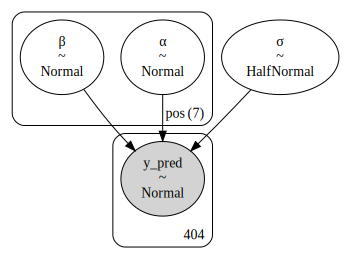

In [ ]:
pm.model_to_graphviz(bat_nh)

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/

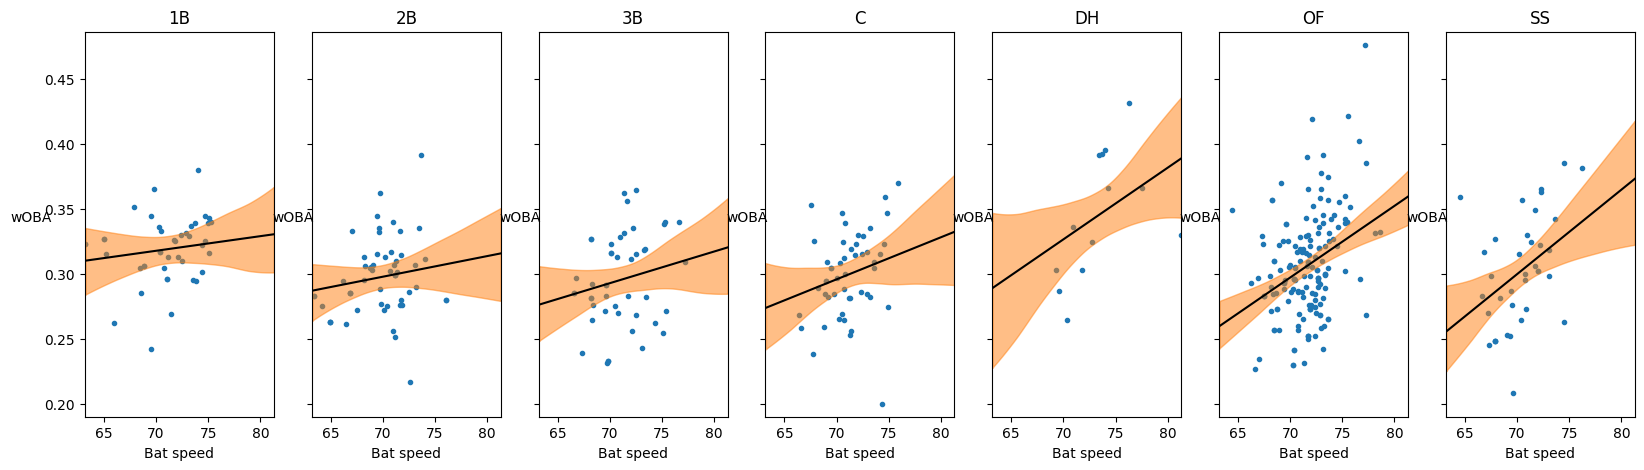

In [ ]:
# normal non-h

#set out our 7 plots
_, ax = plt.subplots(1, 7, figsize=(20, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

#set up x values. Used to graph line of best fit
x_range = np.linspace(bat_woba['avg_bat_speed'].min(), bat_woba['avg_bat_speed'].max(), 10)

#grab posterior info
posterior = az.extract(idata_nh_b1)

#for each position
for i, p in enumerate(pos_codes):
    #plot the raw data
    ax[i].scatter(
        x = bat_woba.query('pos == @p')['avg_bat_speed'],
        y = bat_woba.query('pos == @p')['woba'],
        marker=".")

    #gives our graphs titles and labels
    ax[i].set_title(f"{p}")
    ax[i].set_xlabel("Bat speed")
    ax[i].set_ylabel("wOBA", labelpad=10, rotation=0)

    #grab the slope and y-int
    alphas = posterior["α"].sel(pos=p)
    betas = posterior["β"].sel(pos=p)
    alpha_m = alphas.mean("sample").item()
    beta_m = betas.mean("sample").item()

    #plot the mean line, or line of best fit
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c="k")

    #plot a 94% HDI of the line of best fit.
    az.plot_hdi(x_range, alphas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])

    #set the limits of our graphs' window
    plt.xlim(bat_woba['avg_bat_speed'].min() - 0.01, bat_woba['avg_bat_speed'].max() + 0.01)
    plt.ylim(bat_woba['woba'].min() - 0.01, bat_woba['woba'].max() + 0.01)

Really interesting - there seems to be less of a correlation than I thought there was. Both the DH and OF positions have a smaller correlation than I expected, and the SS position looks like it has a strong correlation, which I was definitely not expecting, since SS is an infield position. I think the reason for this might be that SS is the most demanding infield position, so low-performing SS offensively might remain on the team due to their defensive prowess, making more people fit in the bottom-left quadrant, and so even if the rest of the data is more dispersed amongst the rest of the quadrants, that "floor" so to speak will increase the correlation.

In [ ]:
# i cant remember if it makes sense to do this
pm.sample_posterior_predictive(idata_nh_b1, model = bat_nh, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

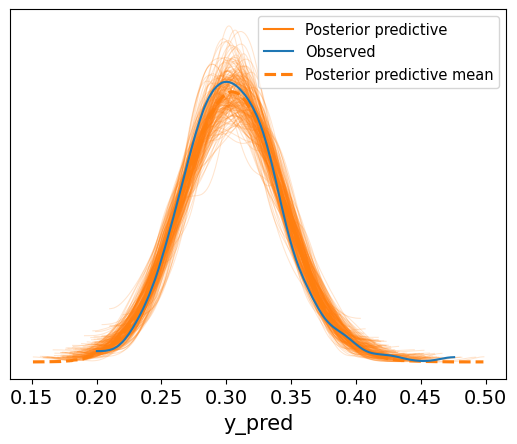

In [ ]:
# i guess it does a little bit at least?
az.plot_ppc(idata_nh_b1, num_pp_samples=200, colors=["C1", "C0", "C1"])

The overall fit is not bad, but could be better. It undershoots the mode a bit, and is seemingly more bullish on the predictive might of bat speed, but generally fits the data decently well, especially on the upswing and initially on the downswing.

## Attempt 2

For my next attempt, I'll try basically the same thing, but with a SkewNormal likelihood instead. This is mainly stemming from the fact that the observed wOBA seems to be skewed a little bit, as the mode was a little off and the downswing was much worse than the upswing, indicating some difference in tail size.

This new model is going to be roughly the same as the first (since it was pretty good as-is), except with a new skew parameter to match the likelihood. This skew, like the standard deviation, will probably be small, so I'm going with another Normal centered around 0 with sigma = 1 to account for that.

<Axes: >

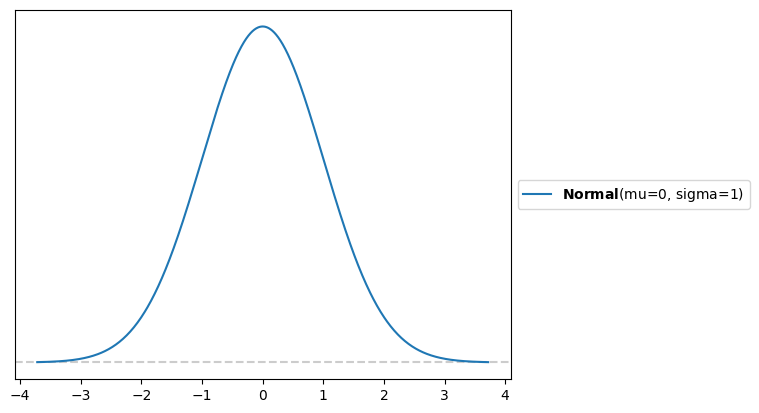

In [ ]:
# skew prior
pz.Normal(mu = 0, sigma = 1).plot_pdf()

In [ ]:
#snnh for skew-normal non-hierarchical
with pm.Model(coords=bsb_coords) as bat_snnh:
    #priors
    α = pm.Normal("α", mu=70, sigma=5, dims="pos")
    β = pm.Normal("β", mu=(0.05 / 2.5), sigma=0.05, dims="pos")
    σ = pm.HalfNormal("σ", 1)
    alpha = pm.Normal("alpha", sigma = 1) # all-new skewnormal parameter

    #likelihood
    #the linear part of the model is put directly into mu
    y = pm.SkewNormal("y_pred",
                  mu=α[pos_idx] + β[pos_idx] * bat_woba['avg_bat_speed'],
                  sigma=σ,
                  alpha=alpha,
                  observed=bat_woba['woba'])
    idata_nh_b2 = pm.sample()

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7ad4c48384c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/scipy.libs/libopenblasp-r0-01191904.3.27.so: cannot open shared object file: No such file or directory
Exception ignored on calling ctypes callback function: <function ThreadpoolCon

Output()

Output()

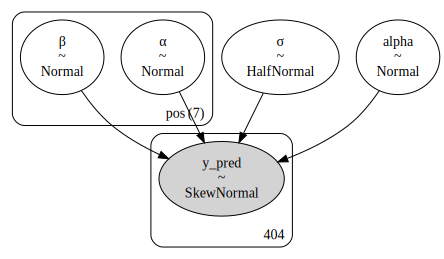

In [ ]:
pm.model_to_graphviz(bat_snnh)

For comparison, here's the first model's posterior:



/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/

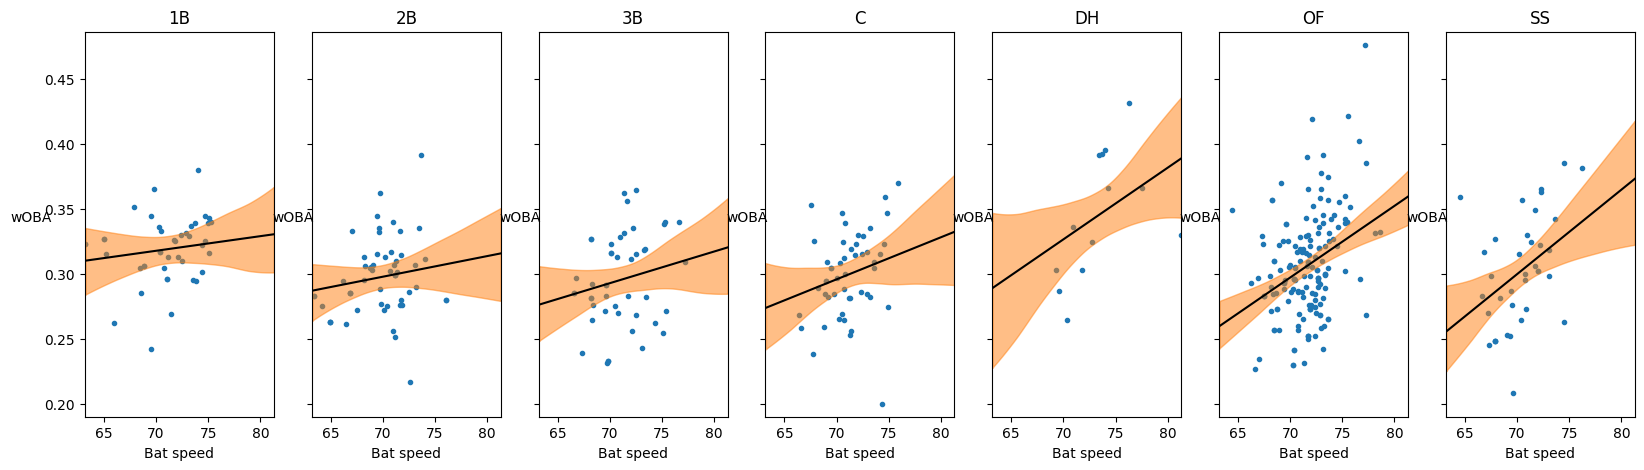

In [ ]:
# normal non-h

#set out our 7 plots
_, ax = plt.subplots(1, 7, figsize=(20, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

#set up x values. Used to graph line of best fit
x_range = np.linspace(bat_woba['avg_bat_speed'].min(), bat_woba['avg_bat_speed'].max(), 10)

#grab posterior info
posterior = az.extract(idata_nh_b1)

#for each position
for i, p in enumerate(pos_codes):
    #plot the raw data
    ax[i].scatter(
        x = bat_woba.query('pos == @p')['avg_bat_speed'],
        y = bat_woba.query('pos == @p')['woba'],
        marker=".")

    #gives our graphs titles and labels
    ax[i].set_title(f"{p}")
    ax[i].set_xlabel("Bat speed")
    ax[i].set_ylabel("wOBA", labelpad=10, rotation=0)

    #grab the slope and y-int
    alphas = posterior["α"].sel(pos=p)
    betas = posterior["β"].sel(pos=p)
    alpha_m = alphas.mean("sample").item()
    beta_m = betas.mean("sample").item()

    #plot the mean line, or line of best fit
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c="k")

    #plot a 94% HDI of the line of best fit.
    az.plot_hdi(x_range, alphas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])

    #set the limits of our graphs' window
    plt.xlim(bat_woba['avg_bat_speed'].min() - 0.01, bat_woba['avg_bat_speed'].max() + 0.01)
    plt.ylim(bat_woba['woba'].min() - 0.01, bat_woba['woba'].max() + 0.01)

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/

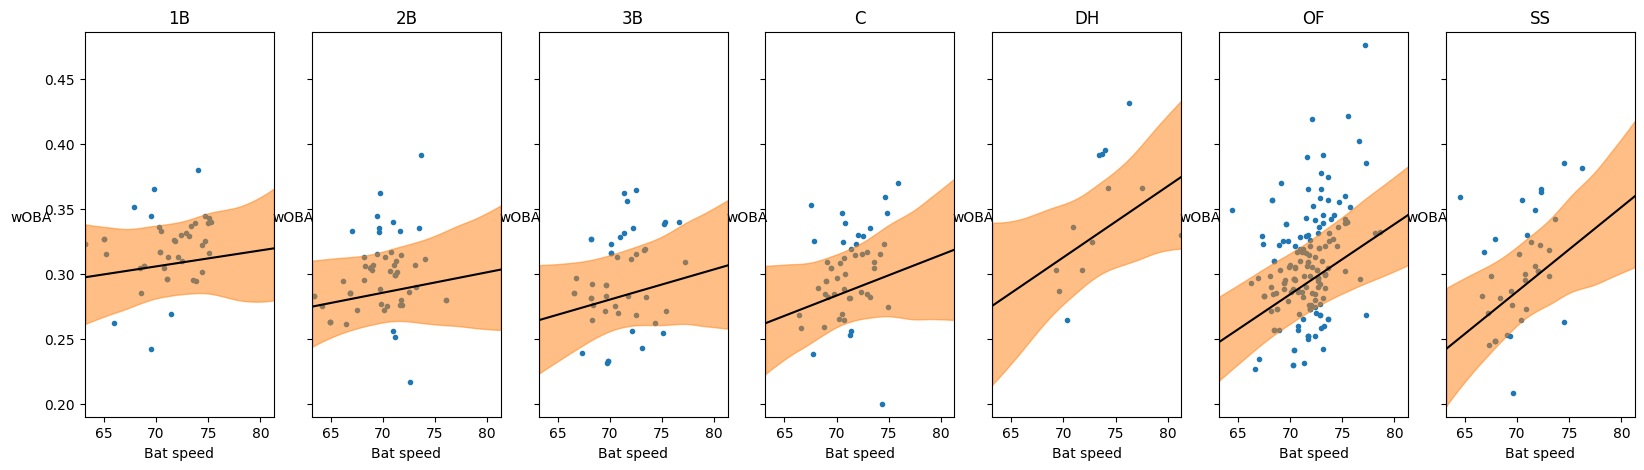

In [ ]:
# skewnormal

#set out our 7 plots
_, ax = plt.subplots(1, 7, figsize=(20, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

#set up x values. Used to graph line of best fit
x_range = np.linspace(bat_woba['avg_bat_speed'].min(), bat_woba['avg_bat_speed'].max(), 10)

#grab posterior info
posterior = az.extract(idata_nh_b2)

#for each position
for i, p in enumerate(pos_codes):
    #plot the raw data
    ax[i].scatter(
        x = bat_woba.query('pos == @p')['avg_bat_speed'],
        y = bat_woba.query('pos == @p')['woba'],
        marker=".")

    #gives our graphs titles and labels
    ax[i].set_title(f"{p}")
    ax[i].set_xlabel("Bat speed")
    ax[i].set_ylabel("wOBA", labelpad=10, rotation=0)

    #grab the slope and y-int
    alphas = posterior["α"].sel(pos=p)
    betas = posterior["β"].sel(pos=p)
    alpha_m = alphas.mean("sample").item()
    beta_m = betas.mean("sample").item()

    #plot the mean line, or line of best fit
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c="k")

    #plot a 94% HDI of the line of best fit.
    az.plot_hdi(x_range, alphas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])

    #set the limits of our graphs' window
    plt.xlim(bat_woba['avg_bat_speed'].min() - 0.01, bat_woba['avg_bat_speed'].max() + 0.01)
    plt.ylim(bat_woba['woba'].min() - 0.01, bat_woba['woba'].max() + 0.01)

Those error bars are HUGE, oh my god. This is probably due to the skew being too lenient. Even then, the mean line is basically the same for both plots, so I'm going to guess that the skew is negligible. Just to make sure, this is what the posterior looks like:

In [ ]:
# snnh posterior sample
pm.sample_posterior_predictive(idata_nh_b2, model = bat_snnh, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

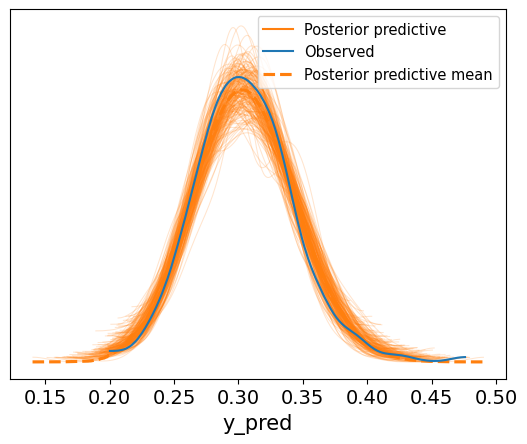

In [ ]:
# plot snnh
az.plot_ppc(idata_nh_b2, num_pp_samples=200, colors=["C1", "C0", "C1"])

Yep, basically no difference. There is effectively no skew in the distribution of wOBAs.

## Attempt 3

Just to see the other side, I'll try out a hierarchical model as well.

I'll keep the likelihood from the more successful Normal experiment, as well as the prior likelihoods (since they worked so well), but I'll additionally add a couple hyperpriors for the alpha and beta parts of the linear model.

For the hyperalpha, I'll just use the prior I used for the non-hierarchical model for mu (Normal with mu = 70, sigma = 5) and a halfnormal with sigma = 5 for the alphasigma. If you remember my reasoning back in attempt 1, I thought the overall average was around 70, with some being above or below; I stil think this, which is why the mu should still be centered around there. The standard deviation implies a sort of weak prior, hopefully centering around something. The same reasoning applies for the beta mu and beta sigma.

<Axes: >

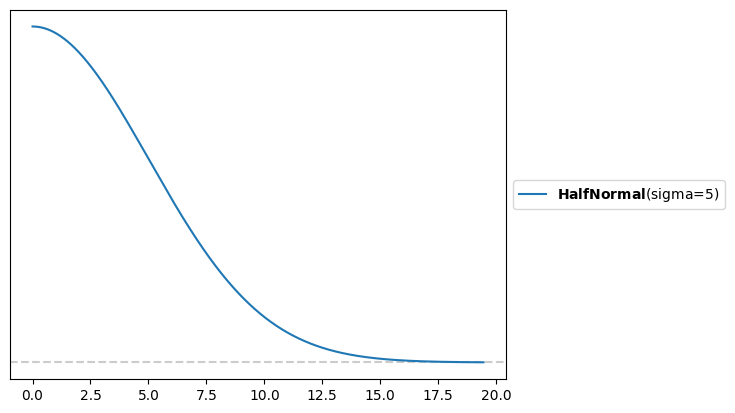

In [ ]:
# alpha sigma
pz.HalfNormal(sigma = 5).plot_pdf()

<Axes: >

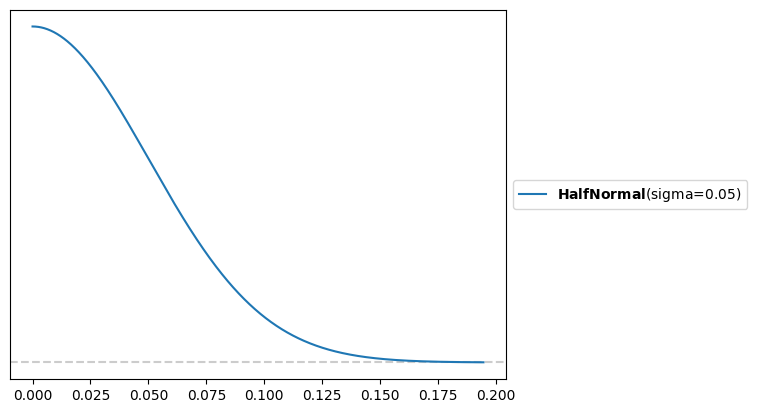

In [ ]:
# beta sigma
pz.HalfNormal(sigma = 0.05).plot_pdf()

In [ ]:
#h for hierachical
with pm.Model(coords=bsb_coords) as bat_h:
    # hyperpriors
    α_mu = pm.Normal("α_mu", mu = 70, sigma=5)
    α_sigma = pm.HalfNormal("α_sigma", 5)
    β_mu = pm.Normal("β_mu", mu = (0.05 / 2.5), sigma = 0.05)
    β_sigma = pm.HalfNormal("β_sigma", 0.05)

    #priors
    α = pm.Normal("α", mu=α_mu, sigma=α_sigma, dims="pos")
    σ = pm.HalfNormal("σ", 1)

    # β offset (because markov chains)
    β_offset = pm.Normal("β_offset", mu=0, sigma=1, dims="pos")
    β = pm.Deterministic("β", β_mu + β_offset * β_sigma, dims="pos")

    #likelihood
    #the linear part of the model is put directly into mu
    y = pm.Normal("y_pred",
                  mu=α[pos_idx] + β[pos_idx] * bat_woba['avg_bat_speed'],
                  sigma=σ,
                  observed=bat_woba['woba'])
    idata_h_b = pm.sample(target_accept = 0.99)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x792b6a2b75b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/scipy.libs/libopenblasp-r0-01191904.3.27.so: cannot open shared object file: No such file or directory
Exception ignored on calling ctypes callback function: <function ThreadpoolCon

Output()

Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/

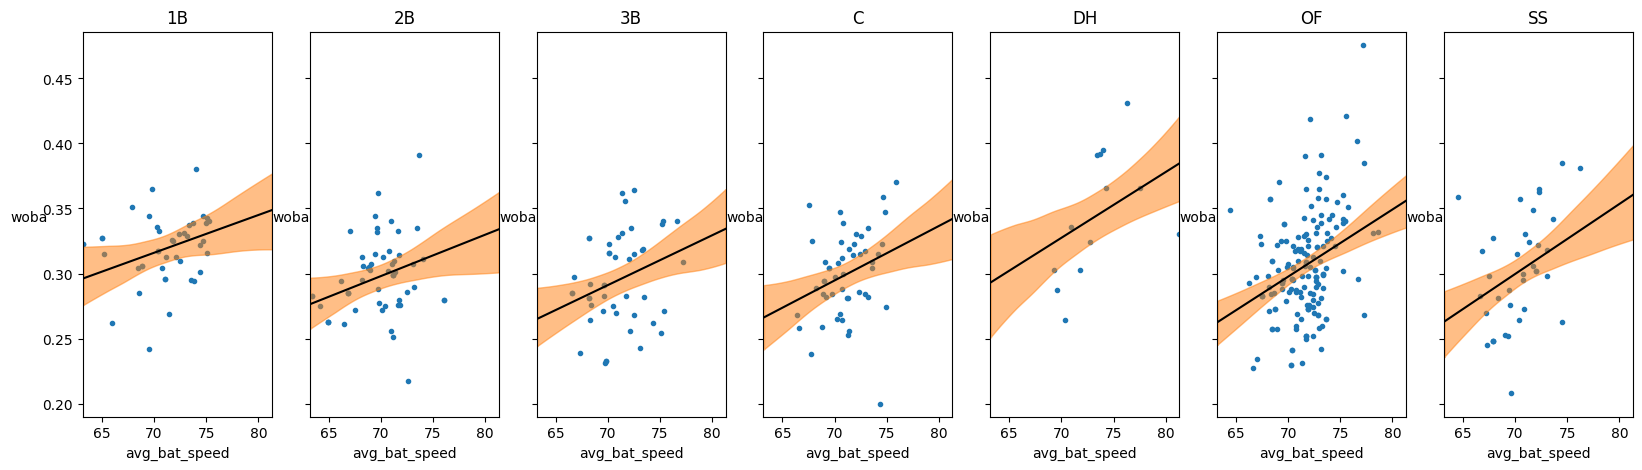

In [ ]:
# hierarchical

#set up plots
_, ax = plt.subplots(1, 7, figsize=(20, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
#x values for putting through our linear equation, in order to graph the line
x_range = np.linspace(bat_woba['avg_bat_speed'].min(), bat_woba['avg_bat_speed'].max(), 10)
#grab the posterior
posterior = az.extract(idata_h_b)

#plot all 7 lines against the data
for i, p in enumerate(pos_codes):
    #plot raw data
    ax[i].scatter(
        x = bat_woba.query('pos == @p')['avg_bat_speed'],
        y = bat_woba.query('pos == @p')['woba'],
        marker=".")
    #titles and labels
    ax[i].set_title(f"{p}")
    ax[i].set_xlabel("avg_bat_speed")
    ax[i].set_ylabel("woba", labelpad=10, rotation=0)
    #grab posterior info
    alphas = posterior["α"].sel(pos=p)
    betas = posterior["β"].sel(pos=p)
    alpha_m = alphas.mean("sample").item()
    beta_m = betas.mean("sample").item()
    #plot the posterior
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c="k")
    az.plot_hdi(x_range, alphas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])
    #set window size
    plt.xlim(bat_woba['avg_bat_speed'].min() - 0.01, bat_woba['avg_bat_speed'].max() + 0.01)
    plt.ylim(bat_woba['woba'].min() - 0.01, bat_woba['woba'].max() + 0.01)

Honestly, this is better than I was expecting. The error bars look somewhat smaller than the non-hierarchical, which makes sense (more data means less uncertainty in the model). There's a pretty clear positive correlation, but some positions only have slightly better correlations than others, unlike the much wider variety found in the non-hierarchical model.

Let's see the posterior predictive:

Output()

<Axes: xlabel='y_pred'>

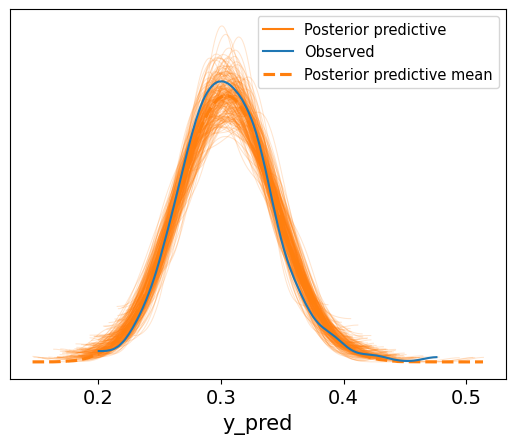

In [ ]:
# hierarchical
pm.sample_posterior_predictive(idata_h_b, model = bat_h, extend_inferencedata=True)

az.plot_ppc(idata_h_b, num_pp_samples=200, colors=["C1", "C0", "C1"])

For comparison, the non-hierarchical Normal model:

Output()

<Axes: xlabel='y_pred'>

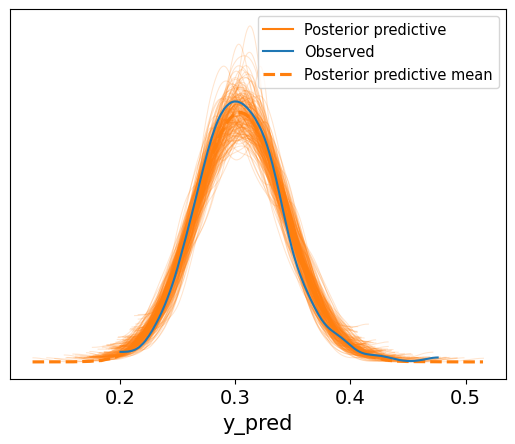

In [ ]:
# non-hierarchical normal
pm.sample_posterior_predictive(idata_nh_b1, model = bat_nh, extend_inferencedata=True)

az.plot_ppc(idata_nh_b1, num_pp_samples=200, colors=["C1", "C0", "C1"])

It's pretty good, but I think the non-hierarchical normal distribution is ever-so-slightly better. The mode is closer, but other than that the two models are basically the same; the downswing is overestimated (curse you Aaron Judge... you and your absurdly good at baseball self messing up my silly little models...), the upswing is dead-on, and the mode is undershot by a little bit. Even though the error bars are smaller on the hierarchical model, the difference in fit overall is so small that I think it doesn't really matter. I expect a difference in correlation amongst positions anyways, as there's a difference in skillsets for each position (power-first positions like DH vs contact-first positions like 2B), so the fact the difference is so small between the two and the slightly better-fit one has more of a difference between positions suggests to me that the non-hierarchical Normal model is better-suited for this task.